### Setup

#simulates the past
#time section to calibrate (train) the models aimming the errors evaluation
#Verify which the patterns in 2 years to see what the behavior each serie (product)
evaluation_initial_month_calibration = (2021,3) #start
evaluation_final_month_calibration = (2023,2) #end

#simulates the future - see Action and Forecast Worksheet
#time section to calculate the errors of the models trainned before.
evaluation_initial_month_validation = (2023,3)
evaluation_final_month_validation = (2023,3)


#time section to calibrate (train) the models aimming the forecast
#Verify which the patterns in 2 years to see what the behavior each serie (product)
forecast_initial_month_calibration = (2021,4)
forecast_final_month_calibration = (2023,3)

#to do Forecast - see Forecast_All_Models Worksheet
forecast_initial_month_validation = (2023,4)
forecast_final_month_validation = (2025,3)

#Considering short memory in last "move_average" months:
move_average=3

In [2]:

# evaluation_initial_month_calibration = (2021,2) #start
# evaluation_final_month_calibration = (2023,1) #end
# evaluation_initial_month_validation = (2023,2)
# evaluation_final_month_validation = (2023,2)
# forecast_initial_month_calibration = (2021,3)
# forecast_final_month_calibration = (2023,2)
# forecast_initial_month_validation = (2023,3)
# forecast_final_month_validation = (2025,2)
# move_average=3

debug=True

#simulates the past
#time section to calibrate (train) the models aimming the errors evaluation
#Verify which the patterns in 2 years to see what the behavior each serie (product)
evaluation_initial_month_calibration = (2022,2) #start
evaluation_final_month_calibration = (2023,12) #end

#simulates the future - see Action and Forecast Worksheet
#time section to calculate the errors of the models trainned before.
evaluation_initial_month_validation = (2024,1)
evaluation_final_month_validation = (2024,1)


#time section to calibrate (train) the models aimming the forecast
#Verify which the patterns in 2 years to see what the behavior each serie (product)
forecast_initial_month_calibration = (2022,3)
forecast_final_month_calibration = (2024,1)

#to do Forecast - see Forecast_All_Models Worksheet
forecast_initial_month_validation = (2024,2)
forecast_final_month_validation = (2026,1)

#Considering short memory in last "move_average" months:
move_average=3

#### Importação de Biliotecas

In [3]:
import pandas as pd
import numpy as np
import asyncio
import datetime as dt
import scipy.signal.signaltools
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
import gc
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from scipy.stats import t
import warnings
warnings.filterwarnings('ignore')#warnings.filterwarnings('default')
plt.rc("figure", figsize=(16, 8))
plt.rc("font", size=14)
xlsx = pd.ExcelFile(r'.\BG_Consolidado.xlsx', engine='openpyxl')
df = pd.read_excel(xlsx)
def get_reshaped_df(df,Date,Key,values):
    df = df.set_index(Date).sort_index().reset_index()
    df['Chave'] = df[Key].astype(str).agg('_'.join, axis=1)#df['Id Produzido'].astype(str) + '_' + df['BG Produzido'].astype(str) + '_' + df['roll_width'].astype(str) + '_' + df['Centro'].astype(str)
    df['Mês'] = df[Date].dt.month
    df['Ano'] = df[Date].dt.year
    grupo = df.pivot_table(values=values, index=['Ano', 'Mês'], columns=['Chave'], aggfunc=np.sum)
    return grupo
grupo = get_reshaped_df(df=df,
                        Date='Data',
                        Key=['Id Original', 'BG Original', 'roll_width', 'Centro'],
                        values='Peso Total Produzido')
grupo

Chave     1003_B 185-160-185/PD_2190_B123  1003_B 185-160-185/PD_2400_B123  \
Ano  Mês                                                                     
2022 2                                NaN                              NaN   
     3                                NaN                              NaN   
     4                                NaN                              NaN   
     5                                NaN                              NaN   
     6                                NaN                              NaN   
     7                                NaN                              NaN   
     8                                NaN                              NaN   
     9                                NaN                              NaN   
     10                               NaN                              NaN   
     11                               NaN                              NaN   
     12                               NaN                              NaN   
2023 1                                NaN                              NaN   
     2                                NaN                              NaN   
     3                                NaN                              NaN   
     4                                NaN                              NaN   
     5                                NaN                              NaN   
     6                                NaN                              NaN   
     7                                NaN                              NaN   
     8                                NaN                              NaN   
     9                                NaN                              NaN   
     10                        410.277312                              NaN   
     11                               NaN                              NaN   
     12                               NaN                      4345.139814   
2024 1                                NaN                              NaN   

Chave     1003_B 185-160-185/PD_2450_B123  1003_B 185-160-185/PD_2500_B123  \
Ano  Mês                                                                     
2022 2                                NaN                              NaN   
     3                                NaN                              NaN   
     4                                NaN                              NaN   
     5                                NaN                              NaN   
     6                                NaN                              NaN   
     7                                NaN                              NaN   
     8                                NaN                              NaN   
     9                                NaN                              NaN   
     10                               NaN                              NaN   
     11                               NaN                              NaN   
     12                               NaN                      2193.590226   
2023 1                                NaN                              NaN   
     2                                NaN                              NaN   
     3                                NaN                              NaN   
     4                        5468.527748                              NaN   
     5                       20098.770931                     12993.192841   
     6                                NaN                              NaN   
     7                                NaN                              NaN   
     8                                NaN                              NaN   
     9                                NaN                              NaN   
     10                      25468.861318                              NaN   
     11                       8840.832352                              NaN   
     12                      17912.873931                              NaN   
2024 1               

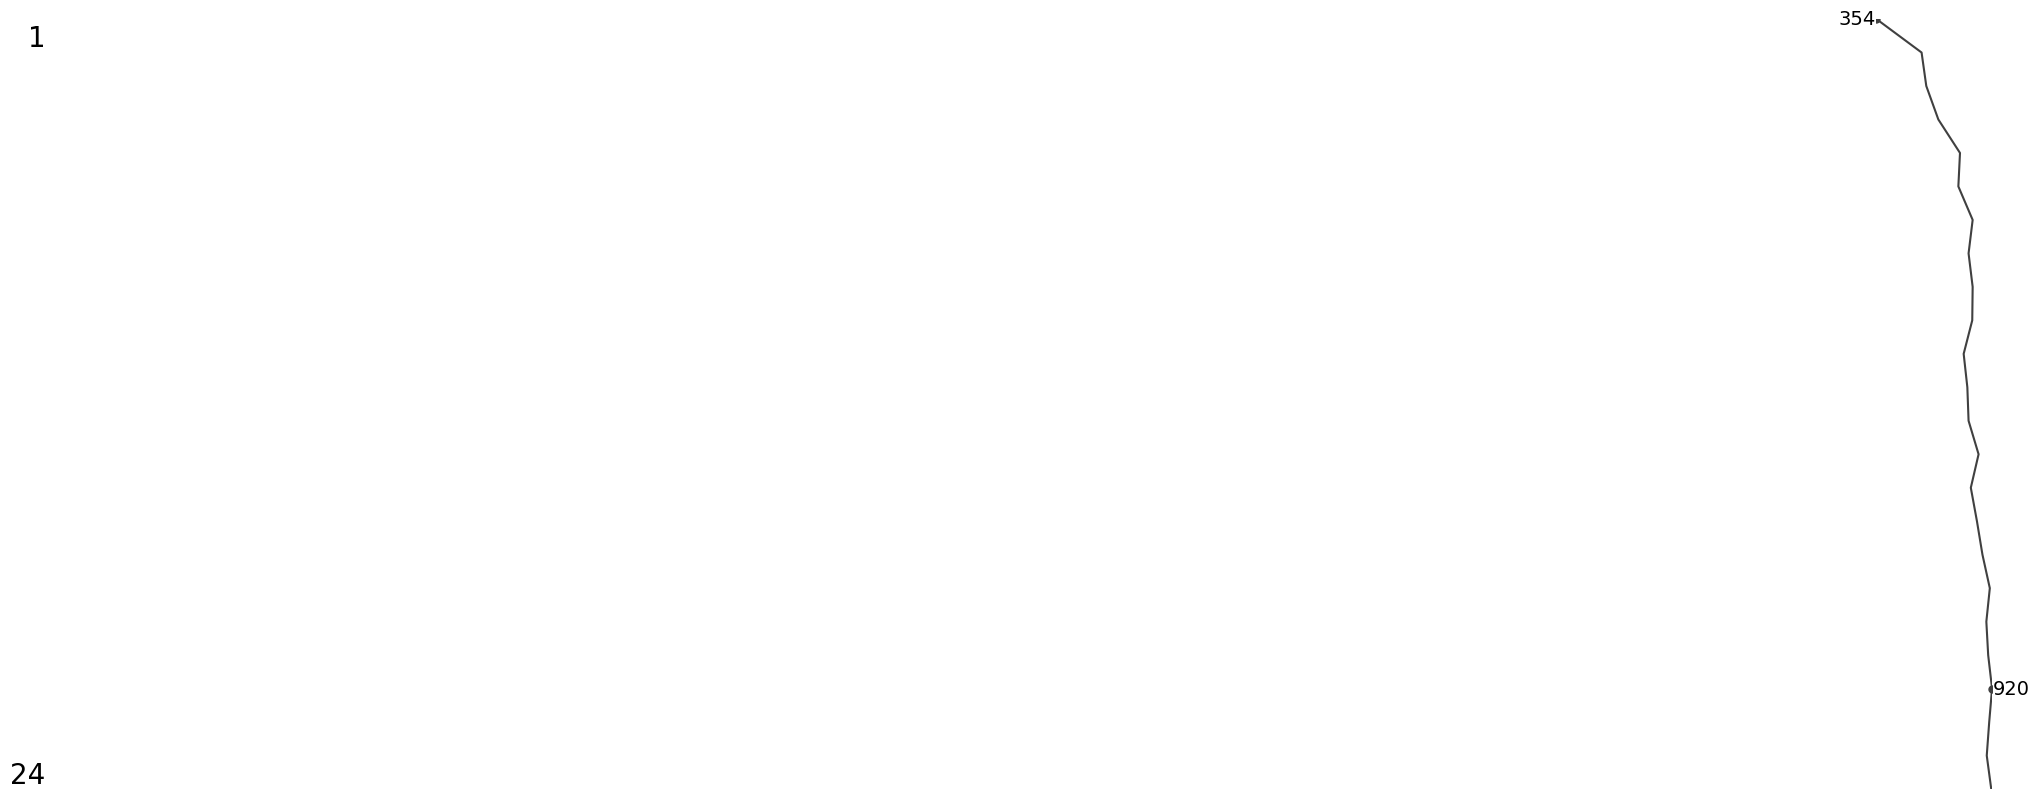

Chave     685_C 120-120-120_1970_B109  750_BC 100-100-100-100-100_2450_B123  \
Ano  Mês                                                                      
2022 2                  106034.282889                                   NaN   
     3                  137622.251683                          20959.458900   
     4                  105233.537404                           9619.643008   
     5                  226376.773419                          35961.446424   
     6                  207760.853852                          49209.434527   
     7                  236791.738542                          34077.974611   
     8                  193177.143310                          22923.686953   
     9                  218063.545011                          65736.067845   
     10                 176916.003135                          28625.222693   
     11                 200665.909611                          50007.420262   
     12                 134012.106951                          36670.758025   
2023 1                  144884.712307                          11954.506195   
     2                   95337.206427                          11615.933378   
     3                    1649.702798                          13464.683872   
     4                  172008.450479                          14089.200189   
     5                  105413.145411                          13981.202254   
     6                  185153.623517                           6054.335052   
     7                  161355.233131                          26850.573828   
     8                  124988.653188                          19056.058769   
     9                  181120.029521                          31671.480658   
     10                 147623.195649                          14747.188680   
     11                  52121.458191                          12723.780958   
     12                 116428.298110                          26232.346761   
2024 1                   86479.351246                          18339.365621   

Chave     574_Z 355-355_1410_B109  645_CB 160-120-120-120-160_1970_B109  \
Ano  Mês                                                                  
2022 2               78638.377165                                   NaN   
     3               18624.466195                          30408.767869   
     4                7510.101206                                   NaN   
     5               16956.687915                          16588.958799   
     6               12888.385891                         126614.786189   
     7               31439.673346                          25904.908378   
     8               27007.815755                         138072.807878   
     9               22100.537261                         110353.495224   
     10              29651.525536                          82915.406185   
     11               7968.566637                          59051.042260   
     12                       NaN                          87309.026133   
2023 1               15621.704611                         135552.112172   
     2               25540.774387                          76333.096342   
     3               36293.496048                         166995.055147   
     4               28197.524390                          77518.605849   
     5               41186.126806                         112459.839730   
     6               57464.512214                         103635.669930   
     7               28328.442854                          62394.096040   
     8               32028.107789                         103777.817418   
     9               41629.508420                          88879.657290   
     10                       NaN                          26647.381622   
     11              30774.484339                          51697.662962   
     12               6516.765965                          89891.165588   
2024 1               30262.030099                          23044.02005

In [4]:
grupo=grupo.replace(0, np.NaN)
grupo.to_excel('.\Dados_mensais.xlsx',freeze_panes=(1,2))
sorted_data = grupo[grupo.isnull().sum().sort_values(ascending=True).index]
import missingno as msno
msno.matrix(sorted_data)
plt.show()
if debug==True:
    grupo=sorted_data.iloc[:,[0,200,300,304,-1,-10]].copy()
grupo = grupo.iloc[:,0:1983]
colunas=grupo.columns
grupo#.loc[(2020,10):(2022,9),:]


In [5]:
def apply_sarima(grupo,evaluation='yes'):
    treino = grupo.to_numpy().copy()
    colunas = grupo.columns.tolist()
    grupo = grupo.to_numpy()
    sarimas = []
    #sarimas=pd.DataFrame()
    for i in range(grupo.shape[1]):
        treino[:,i] = np.nan_to_num(grupo[:,i], nan=0)#.fillna(grupo.iloc[:,i].mean())#################################################################
        if np.isnan(treino[:,i]).sum() == 0:
            if evaluation=='yes':
                ###########grupo.iloc[:-1, i]

                start_year, start_month = evaluation_initial_month_calibration
                end_year, end_month = evaluation_final_month_calibration

                n_months = (end_year - start_year) * 12 + (end_month - start_month)

                #print(colunas[i])

                train_y = treino[:-1, :][:,i].copy()
        
                mask = ~np.isnan(train_y)
                train_y = train_y[mask]

                ##########yearmonth = grupo.index.to_list()[-1]
                tuples = []
                start_year=evaluation_initial_month_validation[0]
                end_year=evaluation_final_month_validation[0]
                start_month=evaluation_initial_month_validation[1]
                end_month=evaluation_final_month_validation[1]
                for year in range(start_year, end_year + 1):
                    start = start_month if year == start_year else 1
                    end = end_month if year == end_year else 12
                    for month in range(start, end + 1):
                        tuples.append((year, month))
                n_forecast = len(tuples)


            else:
                ############train_y = grupo.iloc[:, i]
                # Define as datas de início e fim com base nas variáveis de controle
                start_date = dt.datetime(*evaluation_initial_month_calibration, 1)
                end_date = dt.datetime(*forecast_final_month_validation, 1)
                dates = pd.date_range(start=start_date, end=end_date, freq='MS')
                forecast_initial_index_calibration = dates.get_loc(dt.datetime(*forecast_initial_month_calibration, 1))
                forecast_final_index_calibration = dates.get_loc(dt.datetime(*forecast_final_month_calibration, 1))
                #forecast_initial_index_validation = dates.get_loc(datetime.datetime(*forecast_initial_month_validation, 1))
                #forecast_final_index_validation = dates.get_loc(datetime.datetime(*forecast_final_month_validation, 1))
                train_y = treino[forecast_initial_index_calibration:forecast_final_index_calibration, i].copy()

                mask = ~np.isnan(train_y)
                train_y = train_y[mask]

                ############yearmonth = grupo.index.to_list()[-1]
                ############yearmonth = ((datetime.datetime(yearmonth[0], yearmonth[1], 1) + datetime.timedelta(days=31)).year,
                 ###########(datetime.datetime(yearmonth[0], yearmonth[1], 1) + datetime.timedelta(days=31)).month)
                tuples = []
                start_year=forecast_initial_month_validation[0]
                end_year=forecast_final_month_validation[0]
                start_month=forecast_initial_month_validation[1]
                end_month=forecast_final_month_validation[1]
                for year in range(start_year, end_year + 1):
                    start = start_month if year == start_year else 1
                    end = end_month if year == end_year else 12
                    for month in range(start, end + 1):
                        tuples.append((year, month))
                n_forecast = len(tuples)

            arima_model=pm.auto_arima(train_y, 
            #exogenous= train_X,
             start_p=0, start_q=0, 
             max_p=3, max_q=3, 
             #m=12,d=0,
             max_d=1,
             trace=False, 
             error_action='ignore', 
             suppress_warnings=True, 
             stepwise=True)
               
            ident = pd.MultiIndex.from_tuples(tuples,##################[yearmonth], 
                                              names=["Ano", "Mês"])
            try:
                k = arima_model.predict(n_periods=n_forecast)###################1)
                # print('agora',k,type(k))
            except ValueError:
                if evaluation == 'yes':
                    k=np.zeros(1)
                    # print('OBSERVE ESTA SÉRIE',i,'!!!!!!!!!!!!!!!!!')
                else:
                    k=np.zeros(24)
                    # print('OBSERVE ESTA SÉRIE',i,'!!!!!!!!!!!!!!!!!')
            pass
            #inte=pd.DataFrame(k,columns=[colunas[i]+"-R"],index=ident)
            #print(type(sarimas))
            #print(type(k))
            sarimas= np.concatenate((sarimas, k), axis=0)
            ultima_coluna=colunas[i]+"-R"
        else:
            sarimas[:,i]=np.nan_to_num(grupo[:,i], nan=0).mean()
            ultima_coluna=colunas[i]+"-M"
        #if sarimas.shape[0] == 1:
        if np.isnan(sarimas[i]).sum() == 0:
            sarimas[i]=np.nan_to_num(grupo[:,i], nan=0).mean()
        #else:
        #    print(sarimas)
        #    if np.isnan(sarimas[:,i]).sum() == 0:
        #        sarimas[:,i]=np.nan_to_num(grupo[:,i], nan=0).mean()
    sarimas[sarimas < 0] = 0
    return sarimas
sarimas = apply_sarima(grupo)
#sarimas.to_excel('.\Sarimas_results.xlsx')
sarimas

array([1.46550717e+05, 2.39404904e+04, 2.61095673e+04, 7.48352241e+04,
       1.70948880e+01, 2.42473211e+02])

In [6]:
#Neste bloco é realizada a previsão dos valores para os 3 meses seguintes. A cada iteração é feito a previsão por grupo
#de produto. o Auto_Arima calcula os parâmetros ideias que melhor prevem o modelo. Depois de criado o modelo, ele pode 
#gerar a previsão dos valores futuros para quantos periodos forem necessários, nesse caso foram escolhidos 3 períodos.
#Por fim os valores previstos são exportados em uma planilha excel.

def get_tvalue(X,y):
    lm = LinearRegression()
    lm.fit(X,y)
    params = np.append(lm.intercept_,lm.coef_)
    predictions = lm.predict(X)

    #newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X))
    #MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))

    # Note if you don't want to use a DataFrame replace the two lines above with
    newX = np.append(np.ones((len(X),1)), X, axis=1)
    MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))

    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b
    '''
    p_values =[2*(1-scipy.stats.t.cdf(np.abs(i),(len(newX)-len(newX[0])))) for i in ts_b]
    
    sd_b = np.round(sd_b,3)
    ts_b = np.round(ts_b,3)
    p_values = np.round(p_values,3)
    params = np.round(params,4)

    myDF3 = pd.DataFrame()
    myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilities"] = [params,sd_b,ts_b,p_values]'''
    return(np.round(ts_b[1],0))#p_values[1])
def apply_regression(grupo,evaluation='yes'):
    if evaluation=='yes':
        ###########treino = grupo.iloc[:-1,:].copy()
        treino = grupo.loc[evaluation_initial_month_calibration:evaluation_final_month_calibration,:].copy()
        ##########yearmonth = grupo.index.to_list()[-1]
        tuples = []
        start_year=evaluation_initial_month_validation[0]
        end_year=evaluation_final_month_validation[0]
        start_month=evaluation_initial_month_validation[1]
        end_month=evaluation_final_month_validation[1]
        for year in range(start_year, end_year + 1):
            start = start_month if year == start_year else 1
            end = end_month if year == end_year else 12
            for month in range(start, end + 1):
                tuples.append((year, month))
        n_forecast = len(tuples)
        initial_month = evaluation_initial_month_calibration
    else:
        #############treino = grupo.iloc[:, :].copy()
        treino = grupo.loc[forecast_initial_month_calibration:forecast_final_month_calibration,:].copy()
        ########yearmonth = ((datetime.datetime(yearmonth[0], yearmonth[1], 1) + datetime.timedelta(days=31)).year,
         ##########(datetime.datetime(yearmonth[0], yearmonth[1], 1) + datetime.timedelta(days=31)).month)
        tuples = []
        start_year=forecast_initial_month_validation[0]
        end_year=forecast_final_month_validation[0]
        start_month=forecast_initial_month_validation[1]
        end_month=forecast_final_month_validation[1]
        for year in range(start_year, end_year + 1):
            start = start_month if year == start_year else 1
            end = end_month if year == end_year else 12
            for month in range(start, end + 1):
                tuples.append((year, month))
        n_forecast = len(tuples)
        initial_month = forecast_initial_month_calibration
    tam=treino.shape[1]
    idx = pd.MultiIndex.from_tuples(tuples,##########[yearmonth], 
                                              names=["Ano", "Mês"])
    
    if len(str(initial_month[1]))==1:
        string_yearmonth1=str(initial_month[0])+'0'+str(initial_month[1])+'01'
    else:
        string_yearmonth1=str(initial_month[0])+str(initial_month[1])+'01'
    
    dates = pd.date_range(string_yearmonth1, periods=23, freq='MS')
    for i in range(2,13):
        treino['Dummy'+str(i)]=np.where(dates.month==i,1,0)
    treino
    treino['Tempo']=range(1,treino.shape[0]+1)

    previsao=pd.DataFrame()

    teste=pd.DataFrame(index=idx)
    
    if len(str(initial_month[1]))==1:
        string_yearmonth2=str(initial_month[0])+'0'+str(initial_month[1])+'01'
    else:
        string_yearmonth2=str(initial_month[0])+str(initial_month[1])+'01'
    dates = pd.date_range(string_yearmonth2, periods=n_forecast,freq='MS')#############1, freq='MS')
    for i in range(2,13):
        teste['Dummy'+str(i)]=np.where(dates.month==i,1,0)
    
    teste['Tempo'] = range(treino.shape[0]+1,treino.shape[0]+1+n_forecast)#########1)
    #teste['Future_trend'] = 1
    #teste['Interaction'] = teste['Future_trend']*teste['Tempo']
    #teste['Tempo']=range(36,36+25)
    X=treino[['Tempo', 'Dummy2','Dummy3','Dummy4','Dummy5','Dummy6','Dummy7','Dummy8','Dummy9','Dummy10','Dummy11', 'Dummy12']]
    #X=treino[['Dummy2','Dummy3','Dummy4','Dummy5','Dummy6','Dummy7','Dummy8','Dummy9','Dummy10','Dummy11', 'Dummy12']]
    k=[]
    for i in range(tam):
        #treino.iloc[:,i] = treino.iloc[:,i].fillna(0.1)################################################################
        #if treino.iloc[:,i].isnull().sum() == 0:
        #X['Future_trend'] = 0
        #X['Future_trend'][-trend_months:] = 1
        #X['Interaction'] = X['Future_trend']*X['Tempo']
        regressor = LinearRegression()
        try:
            y_train = treino.iloc[:,i].fillna(0)#.fillna(treino.iloc[:,i].mean())#
            X['Last'] = y_train.shift(1).rolling(window=move_average, min_periods=1).mean().fillna(method='bfill')
            #X['Last'] = y_train.shift(1).fillna(method='bfill')
            regressor.fit(X, y_train)
        except:
            y_train = treino.iloc[:,i].fillna(0)#.fillna(treino.iloc[:,i].mean())#
            X['Last'] = y_train.shift(1).rolling(window=move_average, min_periods=1).mean().fillna(method='bfill')
            regressor.fit(X, y_train)
        k.append(regressor.coef_[0])
        #if ((abs(get_tvalue(X,y_train))==0) and ((y_train == 0).sum() == 0)):
        if ((abs(regressor.coef_[0])<0) and ((y_train == 0).sum() == 0)):# the value 100 is a trend consideration regulator
            #X.loc[:,'Tempo'] = np.log(X.loc[:,'Tempo'])
            #teste['Last'] = y_train[-1]
            regressor.fit(X, y_train)
            teste['Last'] = y_train[-move_average:].mean()
            #teste.loc[:,'Tempo'] = np.log(teste.loc[:,'Tempo'])
            y_pred = pd.DataFrame(regressor.predict(teste),columns=[colunas[i]+"-R"],index=idx)
            #X.loc[:,'Tempo'] = range(1,treino.shape[0]+1)
            #teste.loc[:,'Tempo'] = range(treino.shape[0]+1,treino.shape[0]+1+30)

            #y_train = treino.iloc[:,i].fillna(0)
            #a = (max(y_train)-min(y_train))
            #y_train_transf=((y_train-min(y_train))/a) + 0.0001
            #y_train = y_train+m+0.1
            #regressor.fit(X, np.log(y_train_transf))
            #y_pred = pd.DataFrame((np.exp(regressor.predict(teste))-0.0001)*a,columns=[colunas[i]+"-R"],index=idx)
        else:
            teste['Last'] = y_train[-3:].mean()
            regressor.fit(X.drop(['Tempo'],axis=1), y_train)
            y_pred = pd.DataFrame(regressor.predict(teste.drop(['Tempo'],axis=1)),columns=[colunas[i]+"-R"],index=idx)
            #regressor.fit(X, np.exp(y_train/100000))
            #y_pred = pd.DataFrame(np.log(regressor.predict(teste))*100000,columns=[colunas[i]+"-R"],index=idx)

            #y_train = treino.iloc[:,i].fillna(0)
            #m=abs(min(y_train))
            #y_train = y_train+m+0.1
            #regressor.fit(X, np.log(y_train))
            #y_pred = pd.DataFrame(np.exp(regressor.predict(teste))-m-0.1,columns=[colunas[i]+"-R"],index=idx)  
        previsao= pd.concat([previsao, y_pred], axis=1, join='outer')
        ultima_coluna=colunas[i]+"-R"
    '''    else:
            #previsao[colunas[i]+"_M"]=treino.iloc[:,i].fillna(0).mean()
            previsao[colunas[i]+"-M"]=pd.DataFrame((pd.concat([treino.iloc[:,i].iloc[9:21], 
                                      treino.iloc[:,i].iloc[9:21],
                                      treino.iloc[:,i].iloc[9:15]],
                                      axis=0, join='outer')).values,columns=[colunas[i]+"-M"],index=idx).fillna(0)
            ultima_coluna=colunas[i]+"-M"'''
    if previsao[ultima_coluna].fillna(0).sum() == 0:
        previsao[ultima_coluna]=treino.iloc[:,i].fillna(0).mean()
    previsao[previsao < 0] = 0
    #previsao.T.to_excel('.\Regression_Results.xlsx')
    #previsao.iloc[3:15].T.sum().sum()
    return previsao
previsao = apply_regression(grupo)
previsao

,,685_C 120-120-120_1970_B109-R,750_BC 100-100-100-100-100_2450_B123-R,574_Z 355-355_1410_B109-R,645_CB 160-120-120-120-160_1970_B109-R,1003_B 185-160-185/PD_2190_B123-R,626_C 160-120-160/PD_1800_B105-R
Ano,Mês,,,,,,
2024,1,84408.332746,6689.631412,44188.986296,44134.492739,0.0,5.180389e-13


In [7]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
def apply_expsmoothing(grupo,evaluation='yes'):
    expsmoothing=pd.DataFrame()
    treino2=grupo.copy()
    for i in range(grupo.shape[1]):
        treino2.iloc[:,i] = grupo.iloc[:,i].fillna(grupo.iloc[:,i].mean())#################################################################
        if treino2.iloc[:,i].isnull().sum() == 0:
            if evaluation=='yes':
                ###########grupo.iloc[:-1, i]
                train_y2 = treino2.loc[evaluation_initial_month_calibration:evaluation_final_month_calibration,:].iloc[:,i].copy()
                train_y2=train_y2.dropna()
                ##########yearmonth = grupo.index.to_list()[-1]
                tuples = []
                start_year=evaluation_initial_month_validation[0]
                end_year=evaluation_final_month_validation[0]
                start_month=evaluation_initial_month_validation[1]
                end_month=evaluation_final_month_validation[1]
                for year in range(start_year, end_year + 1):
                    start = start_month if year == start_year else 1
                    end = end_month if year == end_year else 12
                    for month in range(start, end + 1):
                        tuples.append((year, month))
                n_forecast = len(tuples)
            else:
                ############train_y = grupo.iloc[:, i]
                train_y2 = treino2.loc[forecast_initial_month_calibration:forecast_final_month_calibration,:].iloc[:,i].copy()
                train_y2=train_y2.dropna()
                ############yearmonth = grupo.index.to_list()[-1]
                ############yearmonth = ((datetime.datetime(yearmonth[0], yearmonth[1], 1) + datetime.timedelta(days=31)).year,
                 ###########(datetime.datetime(yearmonth[0], yearmonth[1], 1) + datetime.timedelta(days=31)).month)
                tuples = []
                start_year=forecast_initial_month_validation[0]
                end_year=forecast_final_month_validation[0]
                start_month=forecast_initial_month_validation[1]
                end_month=forecast_final_month_validation[1]
                for year in range(start_year, end_year + 1):
                    start = start_month if year == start_year else 1
                    end = end_month if year == end_year else 12
                    for month in range(start, end + 1):
                        tuples.append((year, month))
                n_forecast = len(tuples)
            #print(train_y)
            model3 = ExponentialSmoothing(train_y2, trend='add', seasonal='add', damped_trend=True, seasonal_periods=11)
            fit3 = model3.fit()
            ident = pd.MultiIndex.from_tuples(tuples,##################[yearmonth], 
                                              names=["Ano", "Mês"])
            try:
                k3 = fit3.predict(start=0, end=23+n_forecast)###################1)
                if evaluation=='yes':
                    prediction=k3.iloc[-1]
                else:
                    prediction=k3.iloc[-24:]
            except ValueError:
                k3=0
                print('OBSERVE ESTA SÉRIE !!!!!!!!!!!!!!!!!')
                pass
            if evaluation=='yes':
                inte_=pd.DataFrame({colunas[i]+"-R": prediction},index=ident)
            else:
                inte_=pd.DataFrame({colunas[i]+"-R": prediction.to_list()},index=ident)
            expsmoothing= pd.concat([expsmoothing, inte_], axis=1, join='outer')
            
            ultima_coluna=colunas[i]+"-R"
        else:
            expsmoothing[colunas[i]+"-M"]=grupo.iloc[:,i].fillna(0).mean()
            ultima_coluna=colunas[i]+"-M"
        #if expsmoothing[ultima_coluna].fillna(0).sum() == 0:
        #    expsmoothing[ultima_coluna]=grupo.iloc[:,i].fillna(0).mean()
    expsmoothing[expsmoothing < 0] = 0
    
    return expsmoothing
expsmoothing = apply_expsmoothing(grupo)
expsmoothing

,,685_C 120-120-120_1970_B109-R,750_BC 100-100-100-100-100_2450_B123-R,574_Z 355-355_1410_B109-R,645_CB 160-120-120-120-160_1970_B109-R,1003_B 185-160-185/PD_2190_B123-R,626_C 160-120-160/PD_1800_B105-R
Ano,Mês,,,,,,
2024,1,0.0,2942.619406,49408.429327,137099.396,410.277312,5819.357062


In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

def apply_seasonaldecompose(grupo, evaluation='yes'):
    decompose = pd.DataFrame()
    treino = grupo.copy()
    for i in range(grupo.shape[1]):
        treino.iloc[:,i] = grupo.iloc[:,i].fillna(grupo.iloc[:,i].mean())
        if treino.iloc[:,i].isnull().sum() == 0:
            if evaluation=='yes':
                train_y = treino.iloc[:,i].copy()
                tuples = [(evaluation_initial_month_validation[0], evaluation_initial_month_validation[1])]
                n_forecast = len(tuples)
                index = pd.date_range(start=datetime(*(evaluation_initial_month_calibration+(1,))).date()
                                  , periods=train_y.shape[0], freq='MS')
            else:
                train_y = treino.iloc[:,i].copy()
                start_year = forecast_initial_month_validation[0]
                end_year = forecast_final_month_validation[0]
                start_month = forecast_initial_month_validation[1]
                end_month = forecast_final_month_validation[1]
                tuples = []
                for year in range(start_year, end_year + 1):
                    start = start_month if year == start_year else 1
                    end = end_month if year == end_year else 12
                    for month in range(start, end + 1):
                        tuples.append((year, month))
                n_forecast = len(tuples)
                index = pd.date_range(start=datetime(*(forecast_initial_month_calibration+(1,))).date()
                                  , periods=train_y.shape[0], freq='MS')
            try:
                result = seasonal_decompose(pd.DataFrame(train_y.values,index=index), model='add')
                seasonal = result.seasonal.fillna(method='ffill')
                trend = result.trend.fillna(method='ffill')
                residual = result.resid.fillna(method='ffill')
                forecasted_values = []
                for n in range(n_forecast): 
                    k = trend[-1] + seasonal[(seasonal.index[-1].month + n - 1) % 12] + np.sum(residual[-12:]) / 12 
                    forecasted_values.append(k)
                ident = pd.MultiIndex.from_tuples(tuples, names=["Ano", "Mês"])
                inte=pd.DataFrame(forecasted_values,columns=[treino.columns[i]+"-R"], index=ident)
                decompose = pd.concat([decompose, inte], axis=1, join='outer')
            except ValueError as ve:
                print(f'Error with column {i}: {ve}')
    decompose[decompose < 0] = 0
    return decompose

decompose = apply_seasonaldecompose(grupo)
decompose

,,685_C 120-120-120_1970_B109-R,750_BC 100-100-100-100-100_2450_B123-R,574_Z 355-355_1410_B109-R,645_CB 160-120-120-120-160_1970_B109-R,1003_B 185-160-185/PD_2190_B123-R,626_C 160-120-160/PD_1800_B105-R
Ano,Mês,,,,,,
2024,1,70698.747358,3748.762033,27959.977558,63340.209373,410.277312,5819.357062


In [9]:
# from statsmodels.tsa.seasonal import seasonal_decompose
# def apply_seasonaldecompose(grupo,evaluation='yes'):
#     decompose=pd.DataFrame()
#     treino=grupo.copy()
#     for i in range(grupo.shape[1]):
#         treino.iloc[:,i] = grupo.iloc[:,i].fillna(grupo.iloc[:,i].mean())#################################################################
#         if treino.iloc[:,i].isnull().sum() == 0:
#             if evaluation=='yes':
#                 ###########grupo.iloc[:-1, i]
#                 train_y = treino.loc[evaluation_initial_month_calibration:evaluation_final_month_calibration,:].iloc[:,i].copy()
#                 train_y=train_y.dropna()
#                 ##########yearmonth = grupo.index.to_list()[-1]
#                 tuples = []
#                 start_year=evaluation_initial_month_validation[0]
#                 end_year=evaluation_final_month_validation[0]
#                 start_month=evaluation_initial_month_validation[1]
#                 end_month=evaluation_final_month_validation[1]
#                 for year in range(start_year, end_year + 1):
#                     start = start_month if year == start_year else 1
#                     end = end_month if year == end_year else 12
#                     for month in range(start, end + 1):
#                         tuples.append((year, month))
#                 n_forecast = len(tuples)
#                 index = pd.date_range(start=datetime(*(evaluation_initial_month_calibration+(1,))).date()
#                                   , end=datetime(*(evaluation_final_month_calibration+(1,))).date(), freq='MS')

#             else:
#                 ############train_y = grupo.iloc[:, i]
#                 train_y = treino.loc[forecast_initial_month_calibration:forecast_final_month_calibration,:].iloc[:,i].copy()
#                 train_y=train_y.dropna()
#                 ############yearmonth = grupo.index.to_list()[-1]
#                 ############yearmonth = ((datetime.datetime(yearmonth[0], yearmonth[1], 1) + datetime.timedelta(days=31)).year,
#                  ###########(datetime.datetime(yearmonth[0], yearmonth[1], 1) + datetime.timedelta(days=31)).month)
#                 tuples = []
#                 start_year=forecast_initial_month_validation[0]
#                 end_year=forecast_final_month_validation[0]
#                 start_month=forecast_initial_month_validation[1]
#                 end_month=forecast_final_month_validation[1]
#                 for year in range(start_year, end_year + 1):
#                     start = start_month if year == start_year else 1
#                     end = end_month if year == end_year else 12
#                     for month in range(start, end + 1):
#                         tuples.append((year, month))
#                 n_forecast = len(tuples)
            
#                 index = pd.date_range(start=datetime(*(evaluation_initial_month_calibration+(1,))).date()
#                                   , end=datetime(*(evaluation_final_month_calibration+(1,))).date(), freq='MS')
#             #print(pd.DataFrame(train_y.values,index=index))
#             result = seasonal_decompose(pd.DataFrame(train_y.values,index=index), model='add')
#             ident = pd.MultiIndex.from_tuples(tuples,##################[yearmonth], 
#                                               names=["Ano", "Mês"])
#             try:
#                 seasonal = result.seasonal
#                 trend = result.trend
#                 residual = result.resid
#                 n_periods = 1
#                 trend.fillna(trend.mean(),inplace=True)
#                 residual.fillna(residual.mean(),inplace=True)
#                 k = trend[-1] + seasonal[-1] + np.sum(residual[-12:]) / 12 # forecast for the next period
#             except ValueError:
#                 k=0
#                 print('OBSERVE ESTA SÉRIE !!!!!!!!!!!!!!!!!')
#                 pass
#             if evaluation=='yes':
#                 inte3=pd.DataFrame({colunas[i]+"-R": prediction2},index=ident)
#             else:
#                 inte3=pd.DataFrame({colunas[i]+"-R": prediction2.to_list()},index=ident)
#             #inte3=pd.DataFrame(k,columns=[colunas[i]+"-R"],index=ident)
#             decompose= pd.concat([decompose, inte3], axis=1, join='outer')
#             ultima_coluna=colunas[i]+"-R"
#         else:
#             decompose[colunas[i]+"-M"]=grupo.iloc[:,i].fillna(0).mean()
#             ultima_coluna=colunas[i]+"-M"
#         if decompose[ultima_coluna].fillna(0).sum() == 0:
#             decompose[ultima_coluna]=grupo.iloc[:,i].fillna(0).mean()
#     decompose[decompose < 0] = 0
#     return decompose
# #decompose = apply_seasonaldecompose(grupo)
# decompose = apply_seasonaldecompose(grupo)
# decompose

In [10]:
sarimas=pd.DataFrame([sarimas],columns=grupo.columns,#.to_list(),
                     index=pd.MultiIndex.from_tuples([evaluation_initial_month_validation], names=['Ano', 'Mês']))
df_melted = pd.melt(grupo, value_vars=grupo.columns,ignore_index=False).reset_index().fillna(0)
previsao = pd.melt(previsao, value_vars=previsao.columns,ignore_index=False)
previsao['Chave'] = previsao['variable'].str[:-2]
previsao.reset_index(inplace=True)
previsao2=previsao.merge(df_melted, left_on=['Ano','Mês','Chave'],
                        right_on=['Ano','Mês','Chave'],
                        how='left')
previsao2.drop(['Chave'],axis=1,inplace=True)
previsao2 = previsao2.rename(columns={'value_x': 'Forecast', 'value_y': 'Actual'})
previsao2.loc[:,'MAD'] = abs(previsao2.loc[:,'Forecast']-previsao2.loc[:,'Actual'])
previsao2 = previsao2.set_index(['Ano','Mês'])
k=df_melted.loc[~((df_melted['Ano']==grupo.index.to_list()[-1][0]) & (df_melted['Mês']>=grupo.index.to_list()[-1][1]))]
k=k.groupby('Chave').value.agg(['mean']).reset_index()
previsao2['Chave'] = previsao2['variable'].str[:-2]
previsao3=previsao2.reset_index().merge(k, left_on=['Chave'],
                        right_on=['Chave'],
                        how='left')
previsao3.loc[:,'MAD_mean'] = abs(previsao3.loc[:,'mean']-previsao3.loc[:,'Actual'])
sarimas = pd.melt(sarimas, value_vars=sarimas.columns,ignore_index=False)


#sarimas['Chave'] = sarimas['variable'].str[:-2]
sarimas.reset_index(inplace=True)
sarimas.rename(columns={'value': 'Forecast_Sarima'},inplace=True)#,'Chave': 'variable_Sarima'},inplace=True)
previsao4 = previsao3.merge(sarimas, left_on=['Ano','Mês','Chave'],
                        right_on=['Ano','Mês','Chave'],
                        how='left')
previsao4.loc[:,'MAD_Sarima'] = abs(previsao4.loc[:,'Forecast_Sarima']-previsao4.loc[:,'Actual'])
expsmoothing = pd.melt(expsmoothing, value_vars=expsmoothing.columns,ignore_index=False)
expsmoothing['Chave'] = expsmoothing['variable'].str[:-2]
expsmoothing.reset_index(inplace=True)
expsmoothing.rename(columns={'value': 'Forecast_ExpSmooth','variable': 'variable_ExpSmooth'},inplace=True)
previsao5 = previsao4.merge(expsmoothing, left_on=['Ano','Mês','Chave'],
                        right_on=['Ano','Mês','Chave'],
                        how='left')
previsao5.loc[:,'MAD_ExpSmooth'] = abs(previsao5.loc[:,'Forecast_ExpSmooth']-previsao5.loc[:,'Actual'])
decompose = pd.melt(decompose, value_vars=decompose.columns,ignore_index=False)
decompose['Chave'] = decompose['variable'].str[:-2]
decompose.reset_index(inplace=True)
decompose.rename(columns={'value': 'Forecast_Decompose','variable': 'variable_Decompose'},inplace=True)
previsao6 = previsao5.merge(decompose, left_on=['Ano','Mês','Chave'],
                        right_on=['Ano','Mês','Chave'],
                        how='left')
previsao6.loc[:,'MAD_Decompose'] = abs(previsao6.loc[:,'Forecast_Decompose']-previsao6.loc[:,'Actual'])
somas=previsao6.loc[:,['Chave','MAD','MAD_mean','MAD_Sarima','MAD_ExpSmooth','MAD_Decompose']].groupby('Chave').agg(['sum']).reset_index()
somas['Menor']=somas.iloc[:,1:6].idxmin(axis=1)
somas=somas.sort_values('Chave')
previsao6=previsao6.sort_values('Chave')
condicoes = [somas['Menor'] == ('MAD', 'sum'),
    somas['Menor'] == ('MAD_mean', 'sum'),
    somas['Menor'] == ('MAD_Sarima', 'sum'),
    somas['Menor'] == ('MAD_ExpSmooth', 'sum'),
    somas['Menor'] == ('MAD_Decompose', 'sum')]
valores = [previsao6['Forecast'], previsao6['mean'], previsao6['Forecast_Sarima'],previsao6['Forecast_ExpSmooth'],previsao6['Forecast_Decompose']]
previsao6['Forecast_Mixed']= np.select(condicoes, valores)
previsao6.loc[:,'MAD_Mixed'] = abs(previsao6.loc[:,'Forecast_Mixed']-previsao6.loc[:,'Actual'])
forecast_mixed=previsao6.pivot_table(values='Forecast_Mixed', index=['Chave'],
                     columns=['Ano','Mês'],
                     aggfunc=sum,margins=False)

previsao6['variable'] = previsao6['variable'].map(lambda x: x[:-2])
previsao6[['Id Original','BG Original','roll_width','Centro']] = previsao6['variable'].str.split('_', expand=True)
previsao6.drop(['variable','variable_ExpSmooth','variable_Decompose'],axis=1,inplace=True)
previsao6=previsao6[k.columns.tolist()[:2]+previsao6.columns.tolist()[-3:]+previsao6.columns.tolist()[2:-3]]
previsao6['melhor'] = somas['Menor']
previsao6.to_excel('ActualAndForecast_forecaster.xlsx',index=False)
previsao6

,Chave,mean,BG Original,roll_width,Centro,Forecast,Actual,MAD,Chave,mean,...,Forecast_Sarima,MAD_Sarima,Forecast_ExpSmooth,MAD_ExpSmooth,Forecast_Decompose,MAD_Decompose,Forecast_Mixed,MAD_Mixed,Id Original,melhor
4,1003_B 185-160-185/PD_2190_B123,17.838144,B 185-160-185/PD,2190,B123,0.000000e+00,0.000000,0.000000e+00,1003_B 185-160-185/PD_2190_B123,17.838144,...,17.094888,17.094888,410.277312,410.277312,410.277312,410.277312,0.000000e+00,0.000000e+00,1003,"(MAD, sum)"
2,574_Z 355-355_1410_B109,25929.025423,Z 355-355,1410,B109,4.418899e+04,30262.030099,1.392696e+04,574_Z 355-355_1410_B109,25929.025423,...,26109.567285,4152.462815,49408.429327,19146.399228,27959.977558,2302.052541,2.795998e+04,2.302053e+03,574,"(MAD, sum)"
5,626_C 160-120-160/PD_1800_B105,253.015524,C 160-120-160/PD,1800,B105,5.180389e-13,0.000000,5.180389e-13,626_C 160-120-160/PD_1800_B105,253.015524,...,242.473211,242.473211,5819.357062,5819.357062,5819.357062,5819.357062,5.180389e-13,5.180389e-13,626,"(MAD_Sarima, sum)"
3,645_CB 160-120-120-120-160_1970_B109,77087.015609,CB 160-120-120-120-160,1970,B109,4.413449e+04,23044.020057,2.109047e+04,645_CB 160-120-120-120-160_1970_B109,77087.015609,...,74835.224128,51791.204071,137099.396000,114055.375944,63340.209373,40296.189316,4.413449e+04,2.109047e+04,645,"(MAD, sum)"
0,685_C 120-120-120_1970_B109,149162.515415,C 120-120-120,1970,B109,8.440833e+04,86479.351246,2.071019e+03,685_C 120-120-120_1970_B109,149162.515415,...,146550.716908,60071.365661,0.000000,86479.351246,70698.747358,15780.603889,8.440833e+04,2.071019e+03,685,"(MAD, sum)"
1,750_BC 100-100-100-100-100_2450_B123,24184.017558,BC 100-100-100-100-100,2450,B123,6.689631e+03,18339.365621,1.164973e+04,750_BC 100-100-100-100-100_2450_B123,24184.017558,...,23940.490394,5601.124773,2942.619406,15396.746215,3748.762033,14590.603589,2.394049e+04,5.601125e+03,750,"(MAD_Decompose, sum)"


In [11]:
sarimas

,Ano,Mês,Chave,Forecast_Sarima
0,2024,1,685_C 120-120-120_1970_B109,146550.716908
1,2024,1,750_BC 100-100-100-100-100_2450_B123,23940.490394
2,2024,1,574_Z 355-355_1410_B109,26109.567285
3,2024,1,645_CB 160-120-120-120-160_1970_B109,74835.224128
4,2024,1,1003_B 185-160-185/PD_2190_B123,17.094888
5,2024,1,626_C 160-120-160/PD_1800_B105,242.473211


In [12]:
print('Regression WAPE = ',np.round((previsao6.MAD.sum()/previsao6.Actual.sum())*100,0),'%',sep='')
print('Mean WAPE = ',np.round((previsao6.MAD_mean.sum()/previsao6.Actual.sum())*100,0),'%',sep='')
print('Sarima WAPE = ',np.round((previsao6.MAD_Sarima.sum()/previsao6.Actual.sum())*100,0),'%',sep='')
print('ExpSmoothing WAPE = ',np.round((previsao6.MAD_ExpSmooth.sum()/previsao6.Actual.sum())*100,0),'%',sep='')
print('Decompose WAPE = ',np.round((previsao6.MAD_Decompose.sum()/previsao6.Actual.sum())*100,0),'%',sep='')
print('Mixed WAPE = ',np.round((previsao6.MAD_Mixed.sum()/previsao6.Actual.sum())*100,0),'%',sep='')

Regression WAPE = 31.0%
Mean WAPE = 80.0%
Sarima WAPE = 77.0%
ExpSmoothing WAPE = 153.0%
Decompose WAPE = 50.0%
Mixed WAPE = 20.0%


In [13]:
sarimas = apply_sarima(grupo,evaluation='no')
expsmoothing = apply_expsmoothing(grupo,evaluation='no')
decompose = apply_seasonaldecompose(grupo,evaluation='no')
previsao = apply_regression(grupo,evaluation='no')
df_melted = pd.melt(grupo, value_vars=grupo.columns,ignore_index=False).reset_index()
k=df_melted.loc[~((df_melted['Ano']==grupo.index.to_list()[-1][0]) & (df_melted['Mês']>=grupo.index.to_list()[-1][1]))]#.fillna(0)
k=k.groupby('Chave').value.agg(['mean']).reset_index()
# Função para renomear colunas
def rename_columns(row, columns):
    new_columns = {}
    for i, column in enumerate(columns):
        new_columns[column] = row[i]
    return new_columns

# Renomear colunas
k = k.T.rename(columns=rename_columns(k.T.iloc[0], k.T.columns)).iloc[1:,:]
k=k.T

dates = pd.date_range(start=f"{forecast_initial_month_validation[0]}-{forecast_initial_month_validation[1]}", 
                      end=f"{forecast_final_month_validation[0]}-{forecast_final_month_validation[1]}", 
                      freq='MS')
sarimas = pd.DataFrame(sarimas.reshape(-1, len(dates)), columns=[f"Sarima_({date.year}, {date.month})" for date in dates])
sarimas.index=grupo.columns.to_list()
k=k.merge(sarimas,left_index=True, right_index=True, how='outer')

previsao=previsao.T
previsao.index = previsao.index.map(lambda x: x[:-2])
previsao.columns = previsao.columns.map(lambda x: 'Regression_{}'.format(x))
k=k.merge(previsao,left_index=True, right_index=True, how='outer')

expsmoothing=expsmoothing.T
expsmoothing.index = expsmoothing.index.map(lambda x: x[:-2])
expsmoothing.columns = expsmoothing.columns.map(lambda x: 'ExpSmoothing_{}'.format(x))
k=k.merge(expsmoothing,left_index=True, right_index=True, how='outer')

decompose=decompose.T
decompose.index = decompose.index.map(lambda x: x[:-2])
decompose.columns = decompose.columns.map(lambda x: 'Decompose_{}'.format(x))
k=k.merge(decompose,left_index=True, right_index=True, how='outer')

In [14]:
sarimas


,"Sarima_(2024, 2)","Sarima_(2024, 3)","Sarima_(2024, 4)","Sarima_(2024, 5)","Sarima_(2024, 6)","Sarima_(2024, 7)","Sarima_(2024, 8)","Sarima_(2024, 9)","Sarima_(2024, 10)","Sarima_(2024, 11)",...,"Sarima_(2025, 4)","Sarima_(2025, 5)","Sarima_(2025, 6)","Sarima_(2025, 7)","Sarima_(2025, 8)","Sarima_(2025, 9)","Sarima_(2025, 10)","Sarima_(2025, 11)","Sarima_(2025, 12)","Sarima_(2026, 1)"
685_C 120-120-120_1970_B109,146550.716908,23940.490394,26109.567285,74835.224128,17.094888,242.473211,150018.735534,150023.748353,150025.246324,150025.693959,...,150025.884280,150025.884598,150025.884694,150025.884722,150025.884731,150025.884733,150025.884734,150025.884734,150025.884734,150025.884734
750_BC 100-100-100-100-100_2450_B123,25283.291084,25283.291084,25283.291084,25283.291084,25283.291084,25283.291084,25283.291084,25283.291084,25283.291084,25283.291084,...,25283.291084,25283.291084,25283.291084,25283.291084,25283.291084,25283.291084,25283.291084,25283.291084,25283.291084,25283.291084
574_Z 355-355_1410_B109,23533.145798,23533.145798,23533.145798,23533.145798,23533.145798,23533.145798,23533.145798,23533.145798,23533.145798,23533.145798,...,23533.145798,23533.145798,23533.145798,23533.145798,23533.145798,23533.145798,23533.145798,23533.145798,23533.145798,23533.145798
645_CB 160-120-120-120-160_1970_B109,80590.970864,80590.970864,80590.970864,80590.970864,80590.970864,80590.970864,80590.970864,80590.970864,80590.970864,80590.970864,...,80590.970864,80590.970864,80590.970864,80590.970864,80590.970864,80590.970864,80590.970864,80590.970864,80590.970864,80590.970864
1003_B 185-160-185/PD_2190_B123,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
626_C 160-120-160/PD_1800_B105,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [15]:
backup = k

In [16]:
k = backup

In [17]:
k = backup
k=k.reset_index()
#k['Melhor'] = somas["Menor"]
k[['Id Original','BG Original','roll_width','Centro']] = k['index'].str.split('_', expand=True)
k.drop(['index'],axis=1,inplace=True)
k=k[k.columns.tolist()[-3:]+k.columns.tolist()[:-3]]
k
tuples = []
start_year=forecast_initial_month_validation[0]
end_year=forecast_final_month_validation[0]
start_month=forecast_initial_month_validation[1]
end_month=forecast_final_month_validation[1]
for year in range(start_year, end_year + 1):
    start = start_month if year == start_year else 1
    end = end_month if year == end_year else 12
    for month in range(start, end + 1):
        tuples.append((year, month))
n_forecast = len(tuples)
k['Best_model']=somas['Menor'].apply(lambda x: x[0]) 
condicoes = [k['Best_model'] == 'MAD',
    k['Best_model'] == 'MAD_mean',
    k['Best_model'] == 'MAD_Sarima',
    k['Best_model'] == 'MAD_ExpSmooth',
    k['Best_model'] == 'MAD_Decompose']
valores = ['Regression','Mean','Sarima','ExpSmooth','Decompose']
k['Best_model']= np.select(condicoes, valores)
for i in range(n_forecast):
    condicoes = [k['Best_model'] == 'Regression',
    k['Best_model'] == 'Mean',
    k['Best_model'] == 'Sarima',
    k['Best_model'] == 'ExpSmooth',
    k['Best_model'] == 'Decompose']
    valores=[k['Regression_'+str(tuples[i])],k['mean'],
                                       k['Sarima_'+str(tuples[i])],k['ExpSmoothing_'+str(tuples[i])],
                                       k['Decompose_'+str(tuples[i])]]
    k.loc[:,'Mixed_'+str(tuples[i])] = np.select(condicoes, valores)
k.to_excel('forecast_all_models_forecaster.xlsx',index=False)
k

,BG Original,roll_width,Centro,mean,"Sarima_(2024, 2)","Sarima_(2024, 3)","Sarima_(2024, 4)","Sarima_(2024, 5)","Sarima_(2024, 6)","Sarima_(2024, 7)",...,"Mixed_(2025, 4)","Mixed_(2025, 5)","Mixed_(2025, 6)","Mixed_(2025, 7)","Mixed_(2025, 8)","Mixed_(2025, 9)","Mixed_(2025, 10)","Mixed_(2025, 11)","Mixed_(2025, 12)","Mixed_(2026, 1)"
0,B 185-160-185/PD,2190,B123,410.277312,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,205.138656,0.0,0.0,0.0,0.0
1,Z 355-355,1410,B109,28398.456416,23533.145798,23533.145798,23533.145798,23533.145798,23533.145798,23533.145798,...,40915.853743,57159.259179,28328.442854,36094.696625,32663.608669,38616.411401,15061.916583,32709.615705,18120.452013,27959.977558
2,C 160-120-160/PD,1800,B105,5819.357062,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,2909.678531,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CB 160-120-120-120-160,1970,B109,84428.636143,80590.970864,80590.970864,80590.970864,80590.970864,80590.970864,80590.970864,...,60317.094839,106674.749035,31983.504622,107539.866759,73471.305644,32144.713255,30332.372715,78387.995667,71578.272348,49800.481358
4,C 120-120-120,1970,B109,149162.515415,146550.716908,23940.490394,26109.567285,74835.224128,17.094888,242.473211,...,149679.127981,165104.168817,134341.120809,78439.466361,120741.286608,82594.087051,56404.936813,63835.240974,73871.635637,36240.065033
5,BC 100-100-100-100-100,2450,B123,25283.291084,25283.291084,25283.291084,25283.291084,25283.291084,25283.291084,25283.291084,...,25283.291084,25283.291084,25283.291084,25283.291084,25283.291084,25283.291084,25283.291084,25283.291084,25283.291084,25283.291084


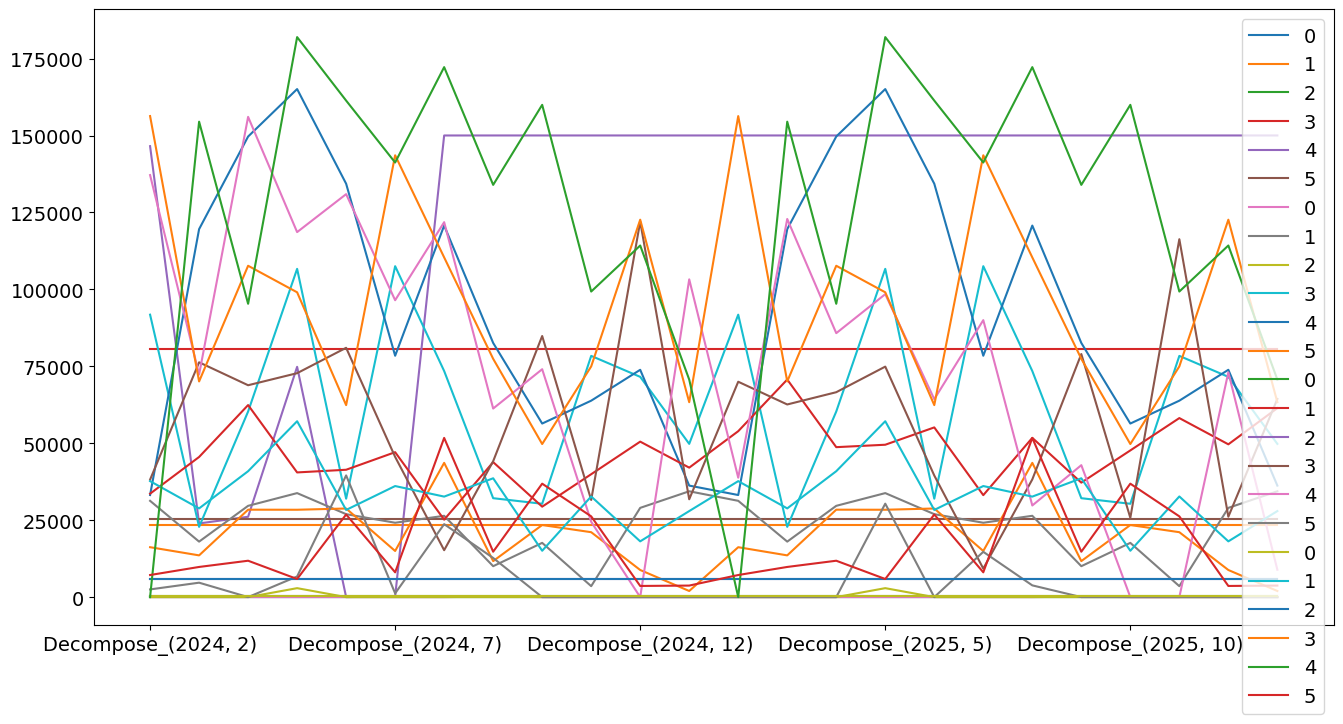

In [18]:
if debug==True:
    ax=k.T.iloc[4:28,:].plot()
    ax2=k.T.iloc[28:(28+24),:].plot(ax=ax)
    ax3=k.T.iloc[(28+24):(28+2*24),:].plot(ax=ax2)
    k.T.iloc[(28+2*24):(28+3*24),:].plot(ax=ax3)

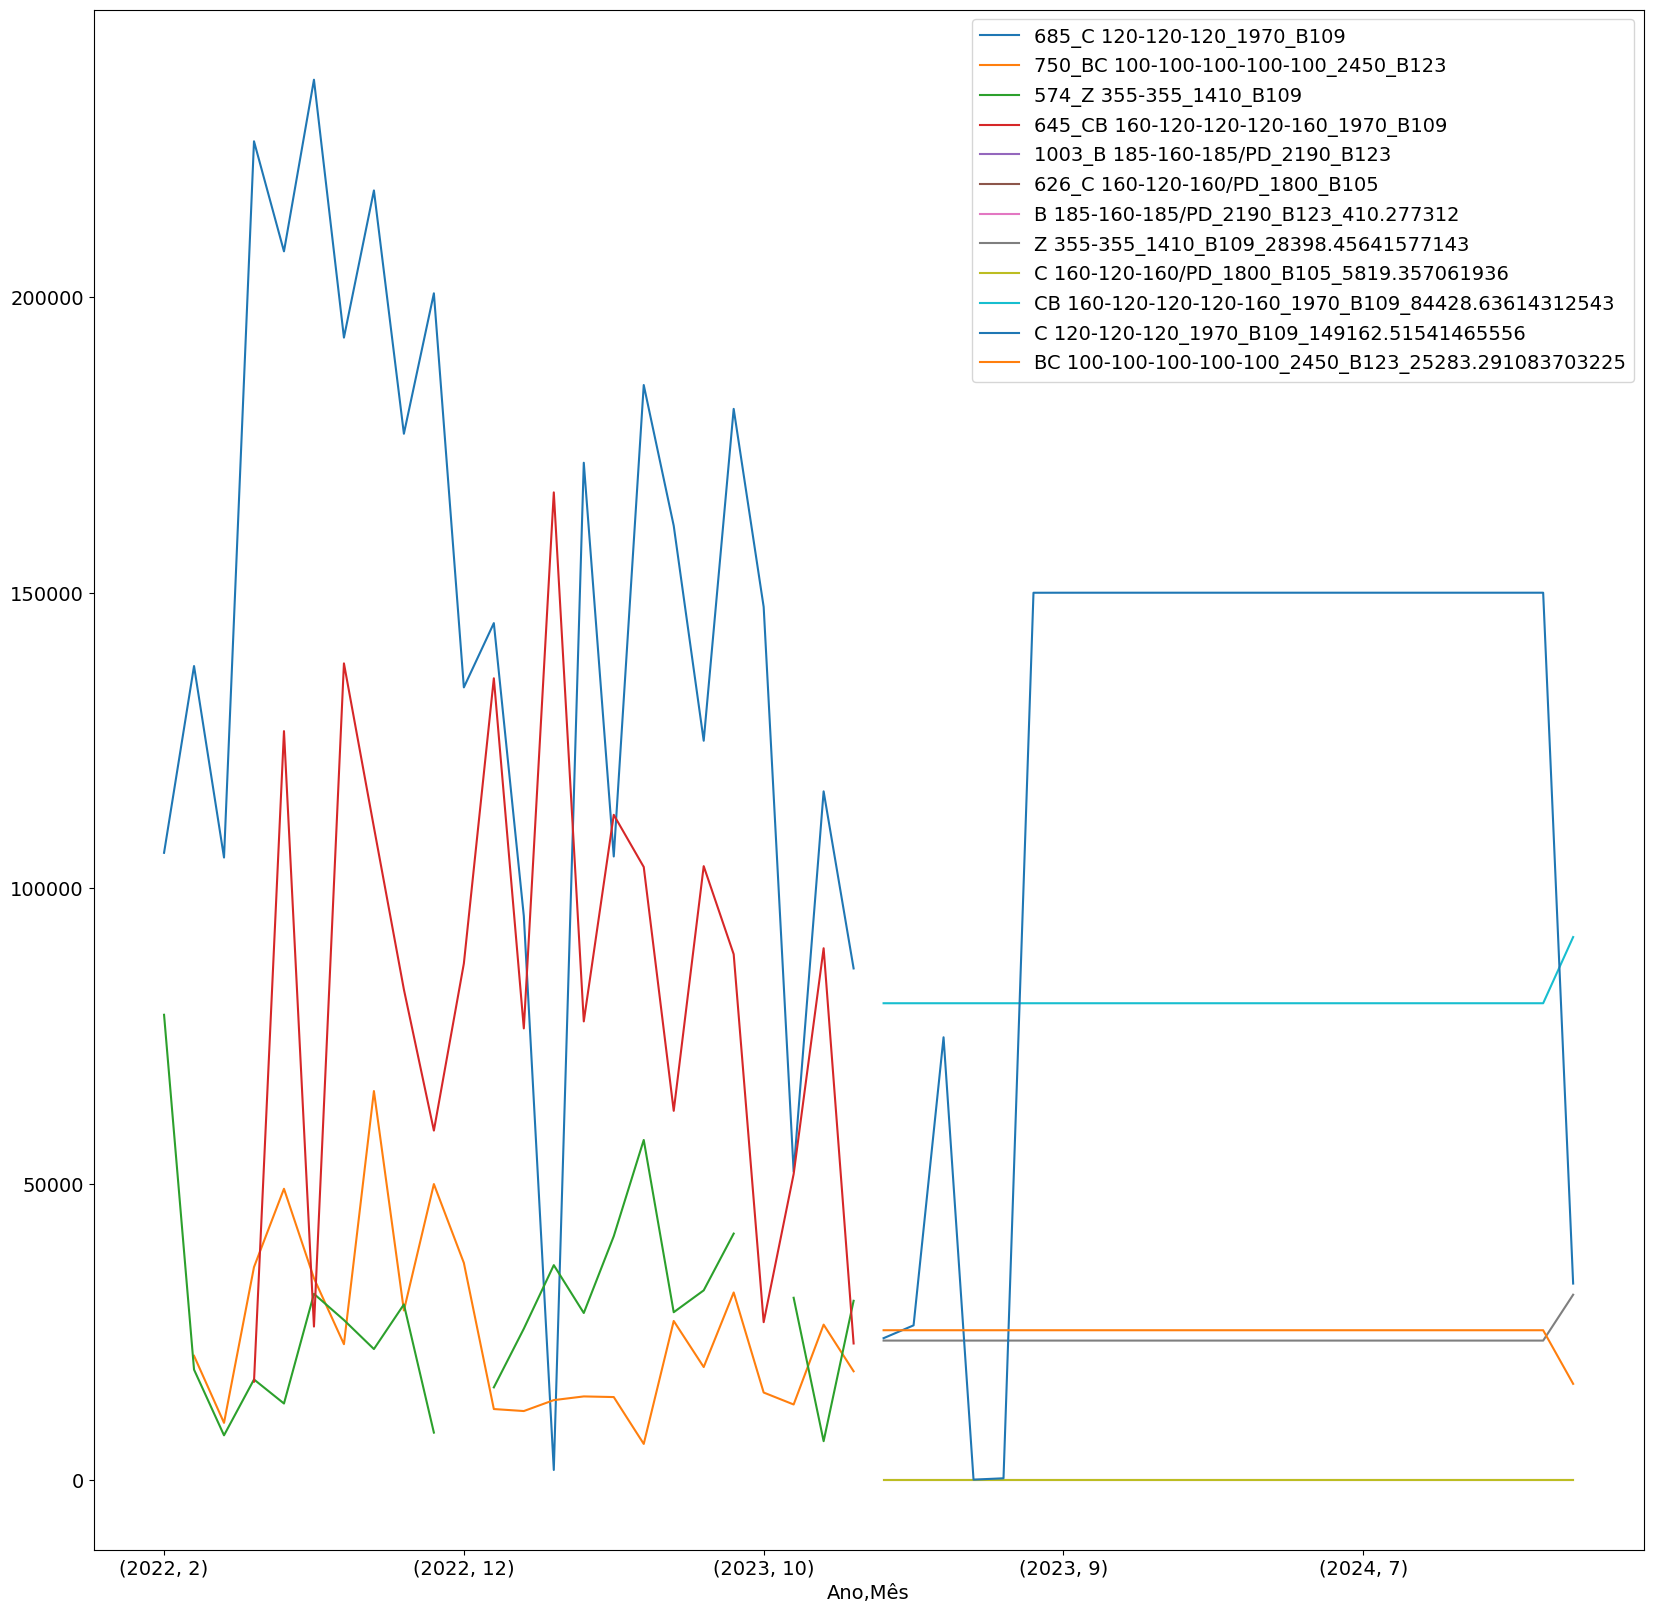

In [19]:
if debug==True:
    pred_ = k.T.iloc[:29,:]
    pred_.columns = k.T.iloc[0:4,:].astype(str).apply('_'.join, axis=0)
    pred_=pred_.iloc[5:29,:]
    dates = pd.date_range(start='2023-03-01', end='2025-03-01', freq='M')
    index = pd.MultiIndex.from_tuples([(date.year, date.month) for date in dates], names=['Ano', 'Mês'])
    pred_.set_index(index, inplace=True)
    # ax=grupo[grupo.mean().sort_values().index].plot(figsize=(20,4))#plota as séries começando com a que tem a menor média
    # pred_.plot(figsize=(20,4),ax=ax)#plota as séries começando com a que tem a menor média
    pd.concat([grupo,pred_]).plot(figsize=(20,20))
    #k.T.iloc[:29,:]

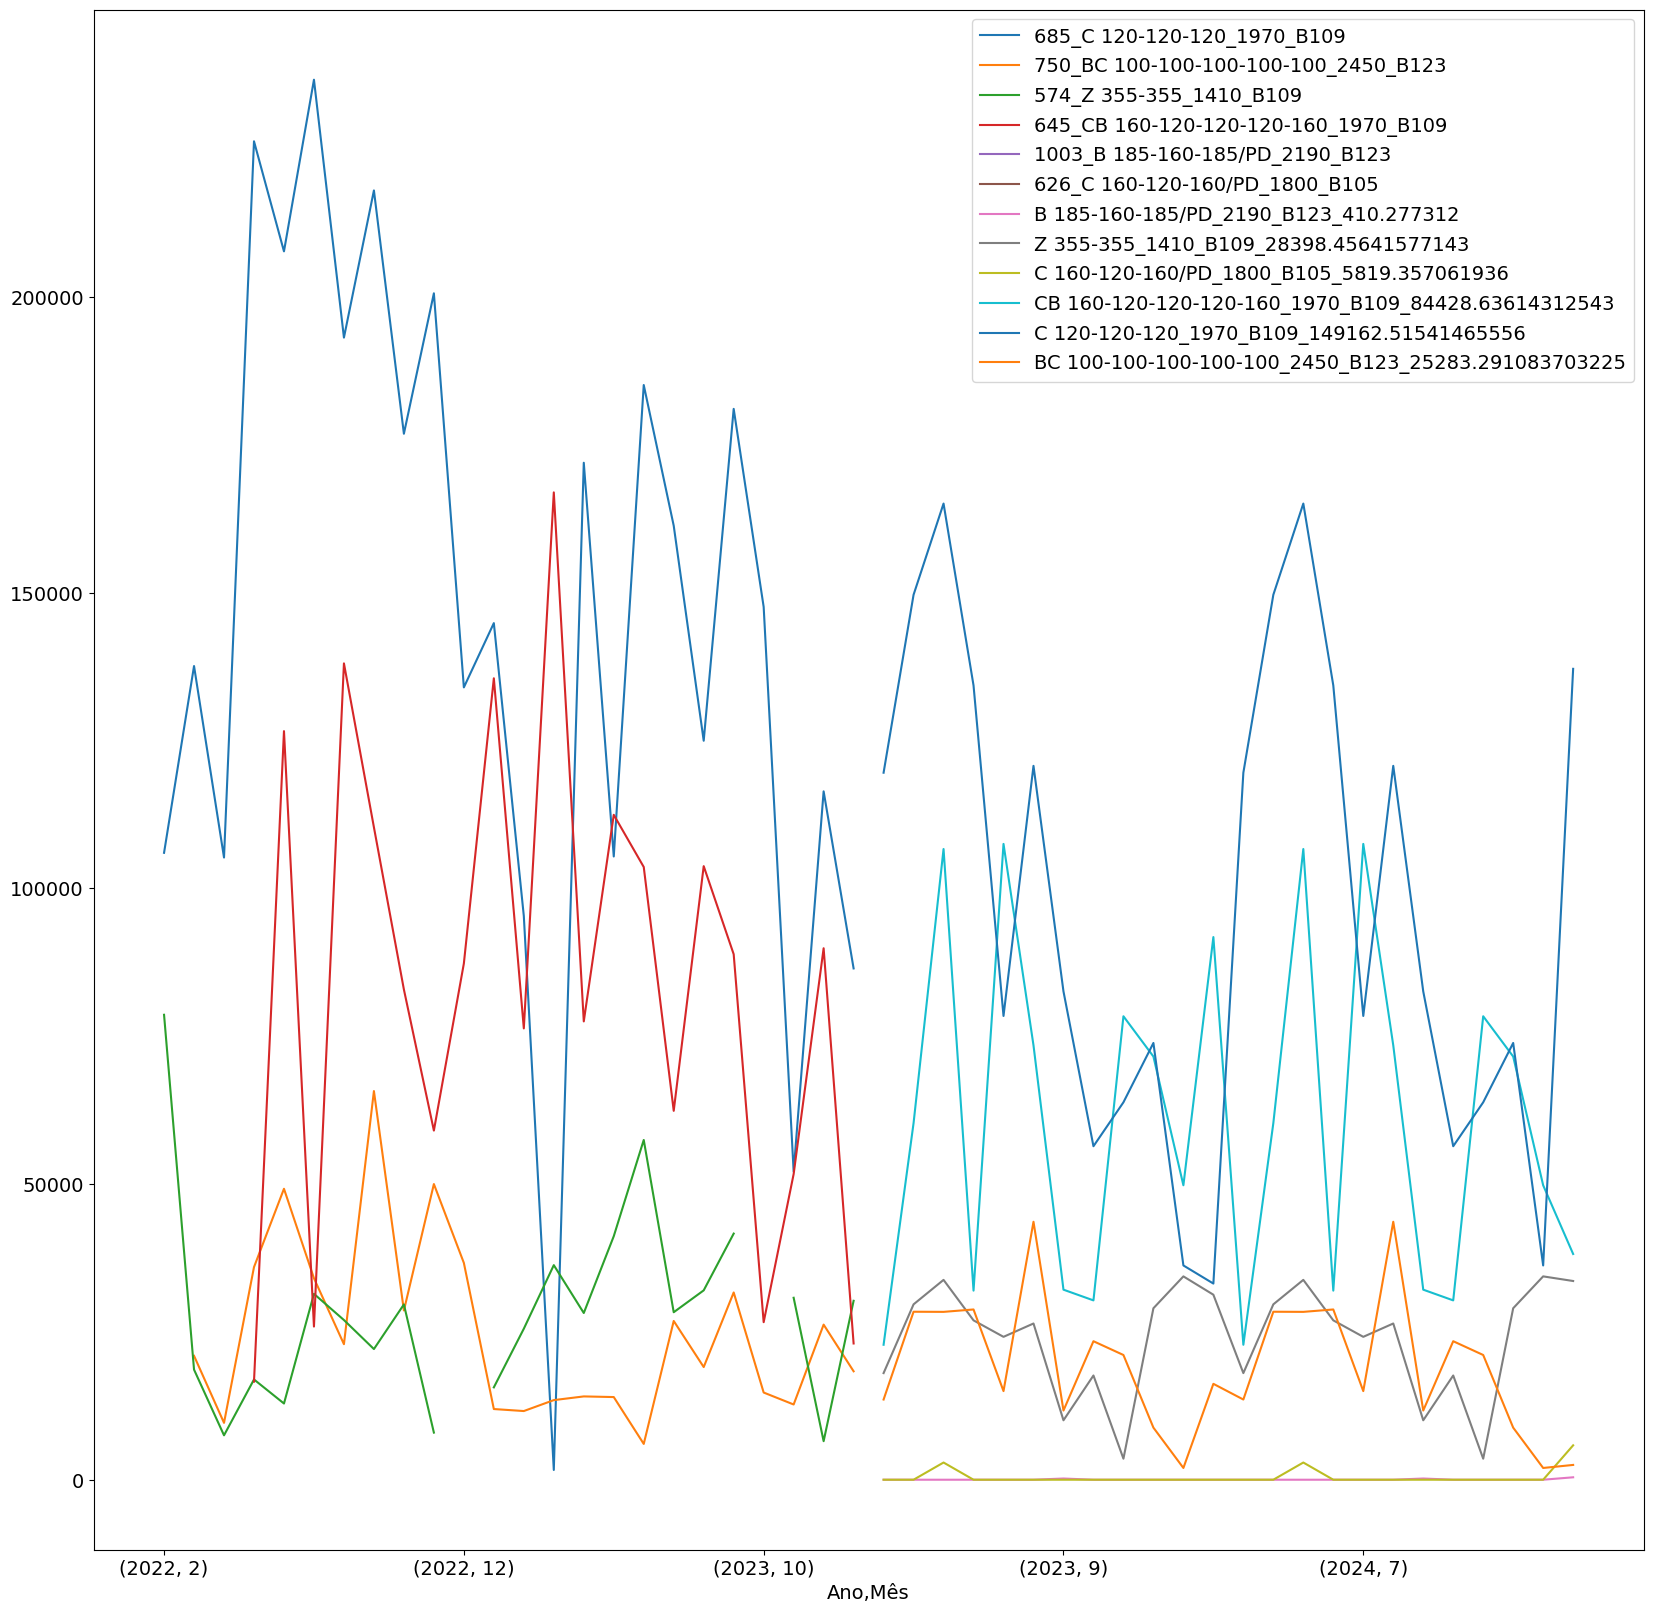

In [20]:
if debug==True:
    pred_ = k.T.iloc[29:53,:]
    pred_.columns = k.T.iloc[0:4,:].astype(str).apply('_'.join, axis=0)
    dates = pd.date_range(start='2023-03-01', end='2025-03-01', freq='M')
    index = pd.MultiIndex.from_tuples([(date.year, date.month) for date in dates], names=['Ano', 'Mês'])
    pred_.set_index(index, inplace=True)
    # ax=grupo[grupo.mean().sort_values().index].plot(figsize=(20,4))#plota as séries começando com a que tem a menor média
    # pred_.plot(figsize=(20,4),ax=ax)#plota as séries começando com a que tem a menor média
    pd.concat([grupo,pred_]).plot(figsize=(20,20))
    #k.T.iloc[29:53,:]


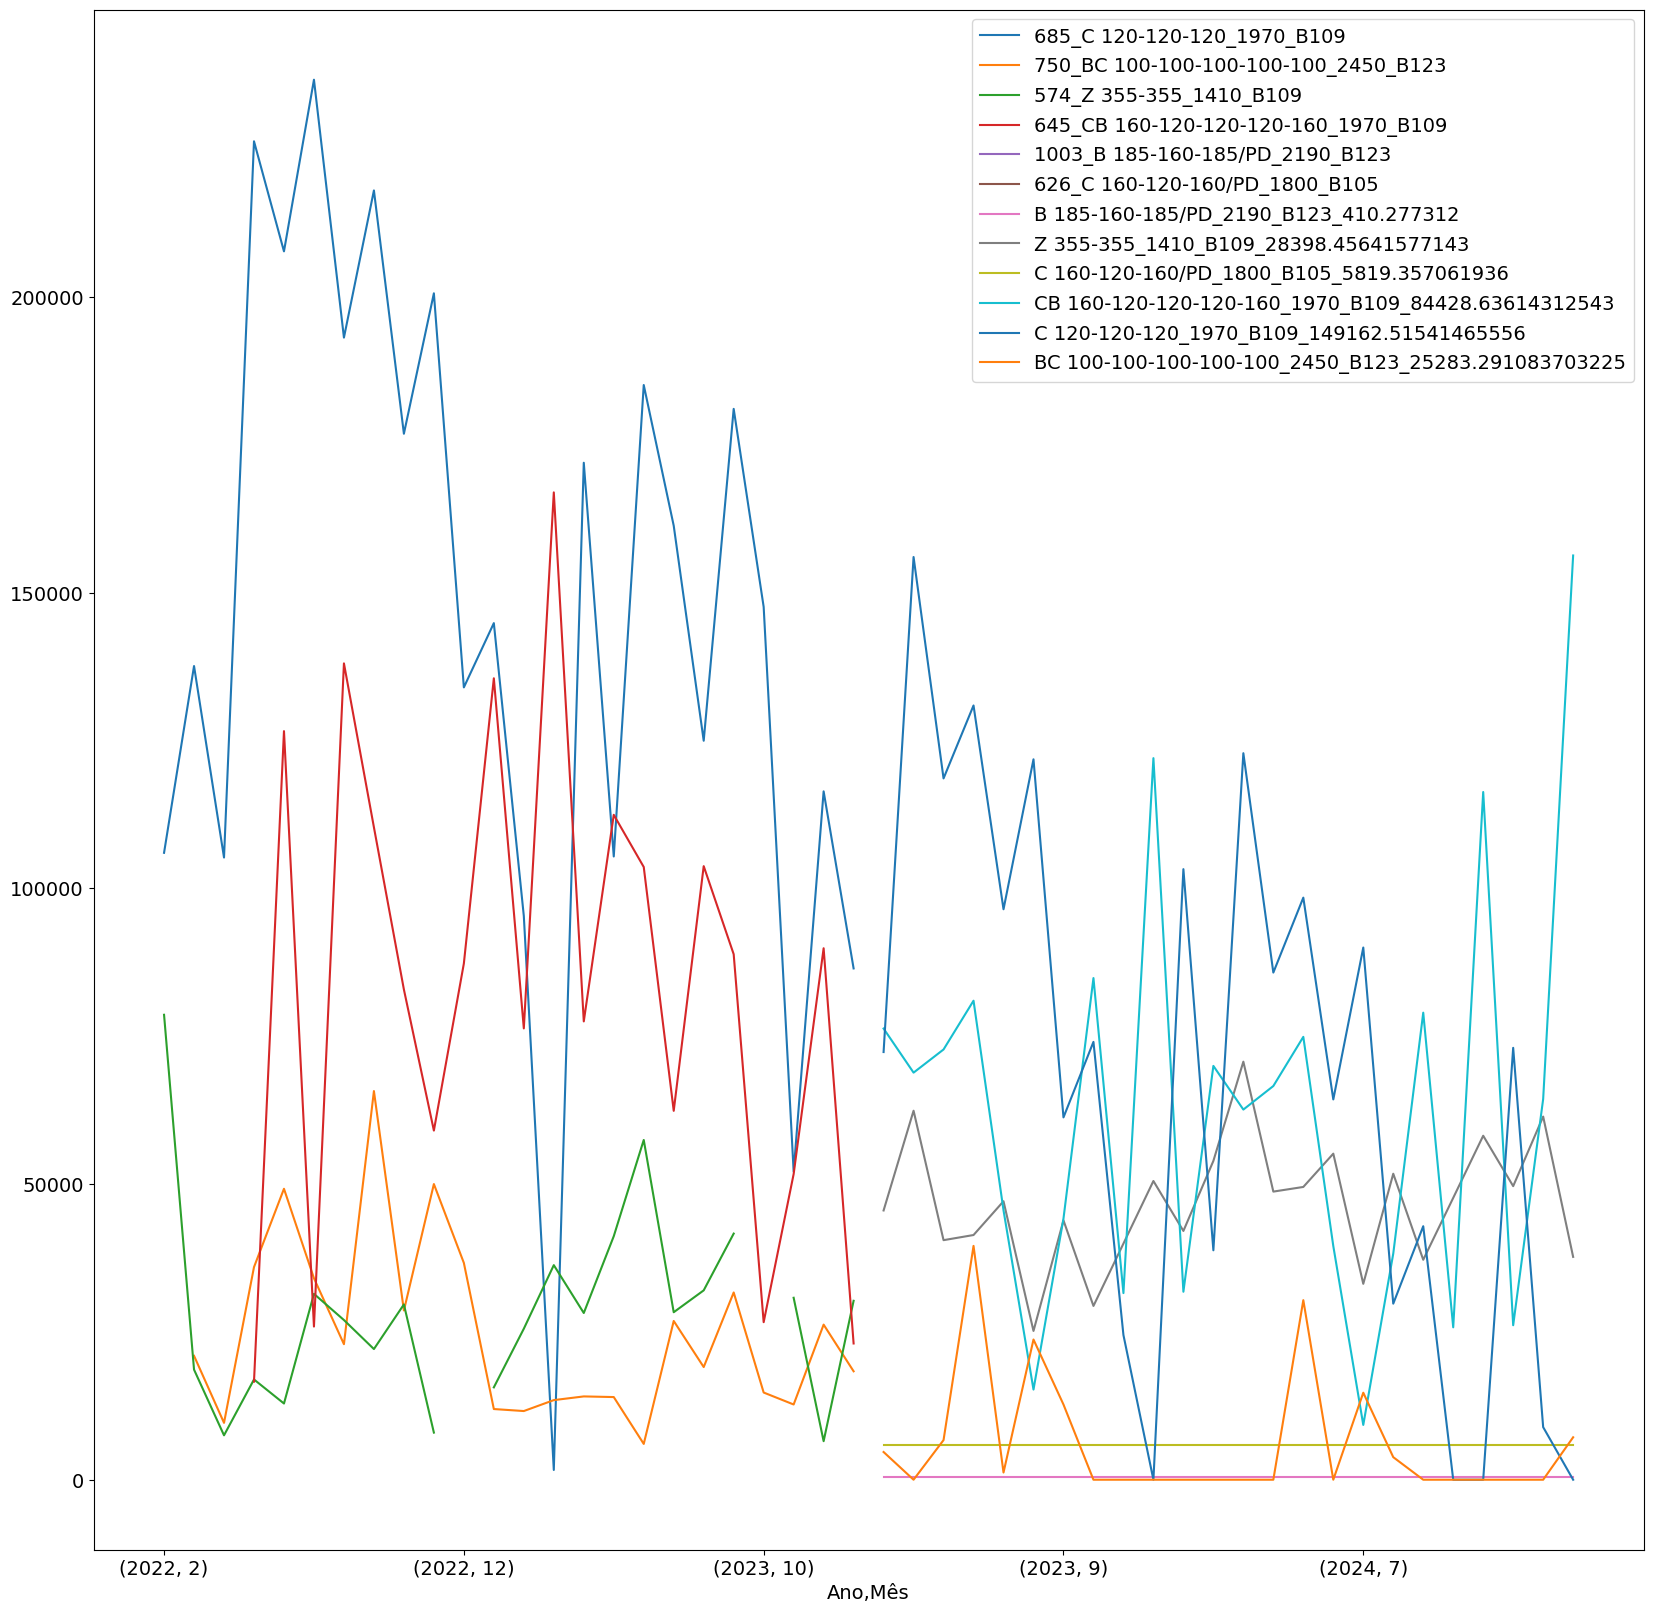

In [21]:
if debug==True:
    pred_ = k.T.iloc[53:77,:]
    pred_.columns = k.T.iloc[0:4,:].astype(str).apply('_'.join, axis=0)
    dates = pd.date_range(start='2023-03-01', end='2025-03-01', freq='M')
    index = pd.MultiIndex.from_tuples([(date.year, date.month) for date in dates], names=['Ano', 'Mês'])
    pred_.set_index(index, inplace=True)
    # ax=grupo[grupo.mean().sort_values().index].plot(figsize=(20,4))#plota as séries começando com a que tem a menor média
    # pred_.plot(figsize=(20,4),ax=ax)#plota as séries começando com a que tem a menor média
    pd.concat([grupo,pred_]).plot(figsize=(20,20))
    #k.T.iloc[53:77,:]

In [22]:
import pandas as pd

# Carregue o arquivo original
file_path = 'forecast_all_models_forecaster.xlsx'
df = pd.read_excel(file_path)

# Filtre as colunas que contêm previsões do modelo "Regression"
regression_columns = [col for col in df.columns if 'Regression' in col]

# Filtrando apenas as colunas que têm algum valor não vazio
regression_forecasts = df[['BG Original', 'roll_width', 'Centro'] + regression_columns].dropna(how='all', axis=1)

# Exporte as previsões para um novo arquivo CSV
output_path = 'regression_forecasts.csv'
regression_forecasts.to_csv(output_path, index=False, sep=';')

print(f"Previsões do modelo 'Regression' exportadas com sucesso para {output_path}")


Previsões do modelo 'Regression' exportadas com sucesso para regression_forecasts.csv


In [2]:
import pandas as pd

# Carregar o arquivo Excel
file_path = 'forecast_all_models_forecaster.xlsx'
df = pd.read_excel(file_path, sheet_name='Sheet1')

# Identificar todas as colunas que contêm o termo 'Mixed'
mixed_columns = [col for col in df.columns if 'Mixed' in col]

# Selecionar as colunas solicitadas junto com todas as colunas 'Mixed'
selected_columns = df[['BG Original', 'roll_width', 'Centro', 'mean'] + mixed_columns + ['Best_model']]

# Renomear a coluna 'Best_model' para 'best model'
selected_columns = selected_columns.rename(columns={'Best_model': 'best model'})

# Salvar o novo dataframe em um arquivo CSV
output_path = 'selected_columns_with_all_mixed_output.csv'
selected_columns.to_csv(output_path, index=False,sep=';')

print(f"Arquivo salvo em: {output_path}")


Arquivo salvo em: selected_columns_with_all_mixed_output.csv
